In [2]:
import tensorflow as tf
#  사전 학습된 모델을 쉽게 불러올 수 있는 라이브러리(pip install numpy==1.26.4)
import tensorflow_hub as hub
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
m = (255, 0, 255)
c = (0, 255, 255)
y = (255, 255, 0)

KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

KEYPOINT_EDGES = {
    (0, 1): m,
    (0, 2): c,
    (1, 3): m,
    (2, 4): c,
    (0, 5): m,
    (0, 6): c,
    (5, 7): m,
    (7, 9): m,
    (6, 8): c,
    (8, 10): c,
    (5, 6): y,
    (5, 11): m,
    (6, 12): c,
    (11, 12): y,
    (11, 13): m,
    (13, 15): m,
    (12, 14): c,
    (14, 16): c
}

In [4]:
def detect_pose(image):

    # input_image = tf.image.resize_with_pad(image, 192, 192)
    input_image = tf.image.resize(image, [192, 192])
    input_image = tf.expand_dims(input_image, axis=0)
    input_image = tf.cast(input_image, dtype=tf.int32)

    # Run model inference
    outputs = movenet(input_image)
    keypoints = outputs['output_0'].numpy()

    return keypoints

In [5]:
def detect_pose(image):

    input_image = tf.image.resize(image, [256, 256])
    input_image = tf.expand_dims(input_image, axis=0)
    input_image = tf.cast(input_image, dtype=tf.int32)

    # Run model inference
    outputs = movenet(input_image)
    keypoints = outputs['output_0'].numpy()

    return keypoints

In [6]:
def draw_keypoints(image, keypoints):
    height, width, confidence = image.shape
    for person in keypoints[0]:
        for edge, color in KEYPOINT_EDGES.items():
            p1, p2 = edge
            y1, x1, c1 = person[p1]
            y2, x2, c2 = person[p2]
            # if c1 > 0.5 and c2 > 0.5:  # Draw lines only for keypoints with confidence > 0.5
            start_point = (int(x1 * width), int(y1 * height))
            end_point = (int(x2 * width), int(y2 * height))
            cv2.line(image, start_point, end_point, color, 2)

        for keypoint in person:
            y, x, c = keypoint
            # if c > 0.5:  # Draw only keypoints with confidence > 0.5
            cv2.circle(image, (int(x * width), int(y * height)), 5, (0, 255, 0), -1)

    return image

In [7]:
def resized_image(image):
    resized_image = cv2.resize(image, (256, 256))
    return resized_image

In [21]:
image_path = "E:/project_data/013.피트니스자세/1.Training/원시데이터/Day04_200924_F/7/A/033-1-1-21-Z3_A/033-1-1-21-Z3_A-0000001.jpg"
image = cv2.imdecode(np.fromfile(image_path, dtype=np.uint8), cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
input_image = tf.convert_to_tensor(image, dtype=tf.int32)

In [17]:
module = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
movenet = module.signatures['serving_default']

In [18]:
keypoints = detect_pose(input_image)

In [25]:
image = cv2.imread("E:/project_data/013.피트니스자세/1.Training/원시데이터/Day04_200924_F/7/A/033-1-1-21-Z3_A/033-1-1-21-Z3_A-0000001.jpg")

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
input_image = tf.convert_to_tensor(image, dtype=tf.float32)

In [19]:
image_keypoints = draw_keypoints(image, keypoints)
image_keypoints.shape

(1080, 1920, 3)

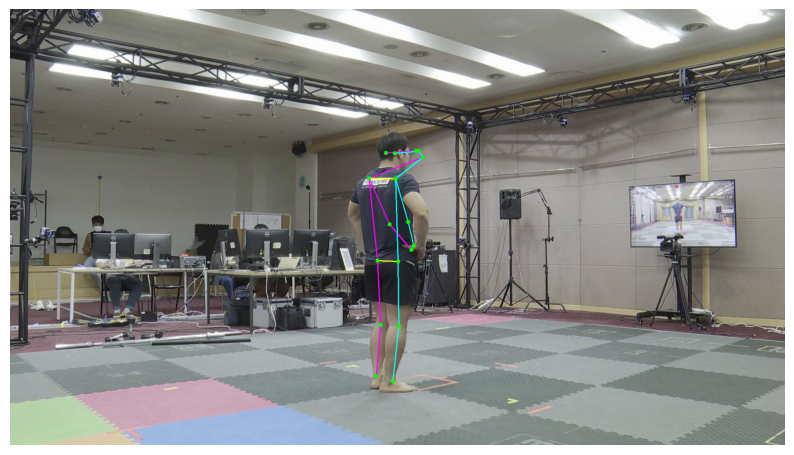

In [22]:
plt.figure(figsize=(10, 10))
# image_keypoints = cv2.cvtColor(image_keypoints, cv2.COLOR_BGR2RGB)
plt.imshow(image_keypoints)
plt.axis('off')
plt.show()

In [29]:
from ultralytics import YOLO
import cv2

def detect_person_yolov8(image_path, model_path="yolov8n.pt", confidence_threshold=0.5):
    """
    YOLOv8을 사용하여 이미지에서 사람 객체를 탐지하는 함수

    Parameters:
        image_path (str): 입력 이미지 경로
        model_path (str): YOLOv8 모델 가중치 파일 (default="yolov8n.pt")
        confidence_threshold (float): 최소 신뢰도 (default=0.5)

    Returns:
        image (np.array): 바운딩 박스가 그려진 이미지
        person_boxes (list): 탐지된 사람 바운딩 박스 리스트 [(x1, y1, x2, y2), ...]
    """
    # YOLOv8 모델 로드
    model = YOLO(model_path)

    # 이미지 로드
    image = cv2.imread(image_path)

    # 객체 탐지 수행
    results = model(image)[0]

    person_boxes = []

    for box in results.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])  # 바운딩 박스 좌표
        confidence = box.conf[0].item()  # 신뢰도
        class_id = int(box.cls[0].item())  # 클래스 ID

        # COCO 데이터셋에서 "person"의 클래스 ID는 0번
        if class_id == 0 and confidence > confidence_threshold:
            person_boxes.append((x1, y1, x2, y2))
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

    return image, person_boxes

In [44]:
image = detect_person_yolov8('/Volumes/ESD-ISO/team_project/project_data/train/Day04_200924_F/1/A/033-1-1-21-Z5_A/033-1-1-21-Z5_A-0000015.jpg')


0: 384x640 1 person, 1 chair, 46.8ms
Speed: 1.5ms preprocess, 46.8ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


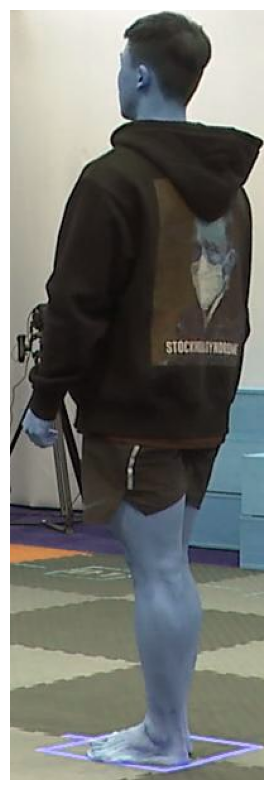

In [45]:
plt.figure(figsize=(10, 10))
# image_keypoints = cv2.cvtColor(image_keypoints, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.axis('off')
plt.show()

In [46]:
from ultralytics import YOLO
import cv2

def detect_person_yolov8(image_path, model_path="yolov8n.pt", confidence_threshold=0.5):
    """
    YOLOv8을 사용하여 이미지에서 사람 객체를 탐지한 후
    가장 신뢰도가 높은 사람 객체 영역만 잘라(crop) 반환하는 함수.

    Parameters:
        image_path (str)            : 입력 이미지 경로
        model_path (str)            : YOLOv8 모델 가중치 파일 (default="yolov8n.pt")
        confidence_threshold (float): 최소 신뢰도 (default=0.5)

    Returns:
        cropped_image (np.array): 가장 신뢰도가 높은 사람 영역이 잘려진 이미지.
                                  사람이 탐지되지 않았을 경우 원본 이미지를 반환.
    """
    # 1. YOLOv8 모델 로드
    model = YOLO(model_path)

    # 2. 이미지 로드
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"이미지를 찾을 수 없습니다: {image_path}")

    # 3. 객체 탐지 수행
    results = model(image)[0]

    # 사람 객체 중 가장 높은 신뢰도의 바운딩 박스를 찾기 위한 변수
    best_confidence = 0.0
    best_box = None

    # 4. 탐지 결과에서 사람 객체(클래스 ID=0)만 확인
    for box in results.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])     # 바운딩 박스 좌표
        confidence = box.conf[0].item()           # 신뢰도
        class_id = int(box.cls[0].item())         # 클래스 ID

        # COCO 데이터셋에서 "person"의 클래스 ID는 0번
        if class_id == 0 and confidence > confidence_threshold:
            if confidence > best_confidence:
                best_confidence = confidence
                best_box = (x1, y1, x2, y2)

    # 5. 가장 신뢰도가 높은 사람 객체만 잘라내기
    if best_box:
        x1, y1, x2, y2 = best_box
        cropped_image = image[y1:y2, x1:x2]
        return resized_image(cropped_image)
    else:
        # 사람이 하나도 탐지되지 않은 경우 원본 이미지를 반환
        return image

In [24]:
from ultralytics import YOLO
import cv2

def detect_person_yolov8_square_crop(image_path, 
                                     model_path="yolov8n.pt",
                                     confidence_threshold=0.5):
    """
    YOLOv8을 사용하여 이미지에서 사람 객체를 탐지한 후,
    바운딩 박스의 가로나 세로 중 더 긴 쪽 길이를 사용해 정사각형으로 잘라서 반환하는 함수.

    Parameters:
        image_path (str)            : 입력 이미지 경로
        model_path (str)            : YOLOv8 모델 가중치 파일 (default="yolov8n.pt")
        confidence_threshold (float): 최소 신뢰도 (default=0.5)

    Returns:
        cropped_image (np.array): 가장 신뢰도가 높은 사람 객체를 
                                  정사각형으로 잘라낸 이미지.
                                  사람이 탐지되지 않은 경우 원본 이미지를 반환.
    """
    # 1. YOLOv8 모델 로드
    model = YOLO(model_path)

    # 2. 이미지 로드
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"이미지를 찾을 수 없습니다: {image_path}")

    H, W, _ = image.shape  # 원본 이미지의 높이, 너비

    # 3. 객체 탐지 수행
    results = model(image)[0]

    # 사람 객체 중 가장 높은 신뢰도의 바운딩 박스를 찾기 위한 변수
    best_confidence = 0.0
    best_box = None

    # 4. 탐지 결과에서 사람 객체(클래스 ID=0)만 확인
    for box in results.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])     # 바운딩 박스 좌표
        confidence = box.conf[0].item()           # 신뢰도
        class_id = int(box.cls[0].item())         # 클래스 ID

        # COCO 데이터셋에서 "person"의 클래스 ID는 0번
        if class_id == 0 and confidence > confidence_threshold:
            if confidence > best_confidence:
                best_confidence = confidence
                best_box = (x1, y1, x2, y2)

    # 5. 가장 신뢰도가 높은 사람 바운딩 박스를 이용해 정사각형 Crop
    if best_box:
        x1, y1, x2, y2 = best_box
        w = x2 - x1
        h = y2 - y1

        # 정사각형 한 변의 길이 (가로나 세로 중 더 큰 길이)
        side = max(w, h)

        # 바운딩 박스 중심 좌표
        center_x = (x1 + x2) / 2
        center_y = (y1 + y2) / 2

        # 정사각형의 좌측 상단 좌표 추정 (float이므로 나중에 int 변환)
        #   예) center_x - side/2 = 정사각형이 왼쪽으로 side/2만큼 이동
        new_x1 = center_x - side / 2
        new_y1 = center_y - side / 2

        # 정사각형의 우측 하단 좌표
        new_x2 = new_x1 + side
        new_y2 = new_y1 + side

        # 이미지 범위를 벗어나지 않도록 clamp(최소 0, 최대 W-1/H-1 등으로 보정)
        #   좌표는 int형이므로 변환 전후를 고려해 보정
        #   먼저 정사각형 한 변이 이미지보다 클 수도 있으므로 side도 보정 필요
        side = min(side, W, H)  # 이미지의 너비, 높이보다 큰 경우는 잘려서라도 측정
        new_x1 = int(max(0, min(W - side, new_x1)))
        new_y1 = int(max(0, min(H - side, new_y1)))
        
        # new_x2, new_y2는 new_x1/new_y1에서 side만큼 떨어진 위치
        new_x2 = new_x1 + int(side)
        new_y2 = new_y1 + int(side)

        # 최종 정사각형 영역을 잘라내기
        cropped_image = image[new_y1:new_y2, new_x1:new_x2]
        cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
        return resized_image(cropped_image)
    else:
        # 사람이 하나도 탐지되지 않은 경우 원본 이미지를 반환
        return image

Creating new Ultralytics Settings v0.0.6 file  
View Ultralytics Settings with 'yolo settings' or at 'C:\Users\dlow1\AppData\Roaming\Ultralytics\settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [26]:
image = detect_person_yolov8_square_crop('E:/project_data/unziped_file/img_temp/Day04_200924_F/1/A/033-1-1-21-Z5_A/033-1-1-21-Z5_A-0000003.jpg')


0: 384x640 1 person, 1 chair, 46.4ms
Speed: 5.0ms preprocess, 46.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


In [93]:
image = detect_person_yolov8_square_crop('/Volumes/ESD-ISO/team_project/project_data/IMG_0428_converted.jpg')


0: 640x480 1 person, 5 tvs, 1 mouse, 1 keyboard, 70.6ms
Speed: 3.1ms preprocess, 70.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


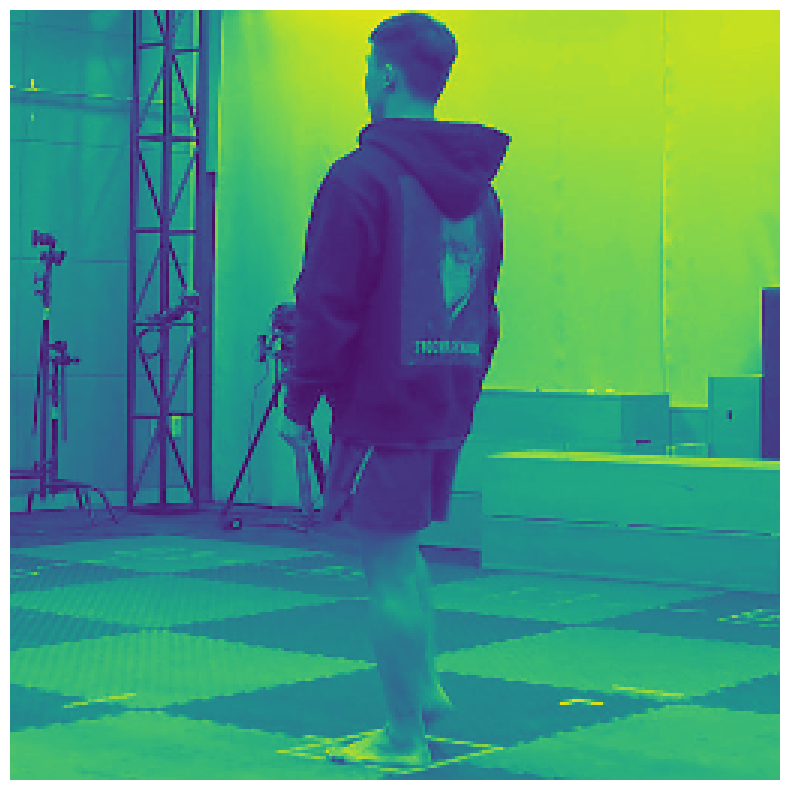

In [27]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.show()

In [84]:
image.shape

(256, 256)

In [92]:
import os

test_path = "/Volumes/ESD-ISO/team_project/project_data/IMG_0428.png"
print(os.path.exists(test_path))  # 존재하면 True, 없으면 False

True
